In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree, plot_predictions

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

In [3]:
#Reading Data and isolating just the required pollutant
col_list = ["Date","SO2"]
data = pd.read_csv("O3Dtr.csv", usecols=col_list,index_col ="Date")
data.head()

,SO2
Date,
1/1/2015,9.25
1/2/2015,6.65
1/3/2015,2.65
1/4/2015,4.63
1/5/2015,3.33


In [4]:
#Dropping null values
data.dropna(subset = ["SO2"], inplace=True)

<AxesSubplot:xlabel='Date'>

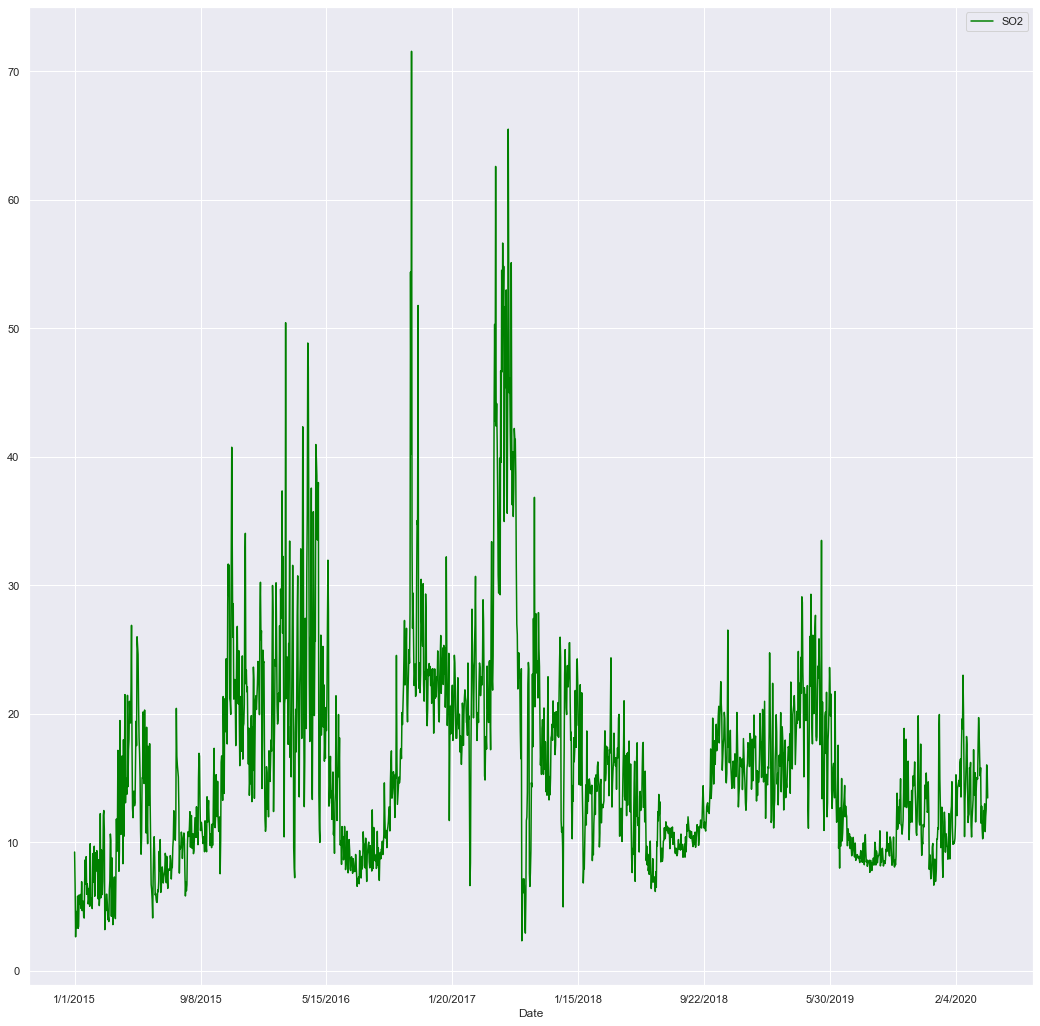

In [5]:
plt.rcParams['figure.figsize'] = [18, 18]
data.plot(color='green')

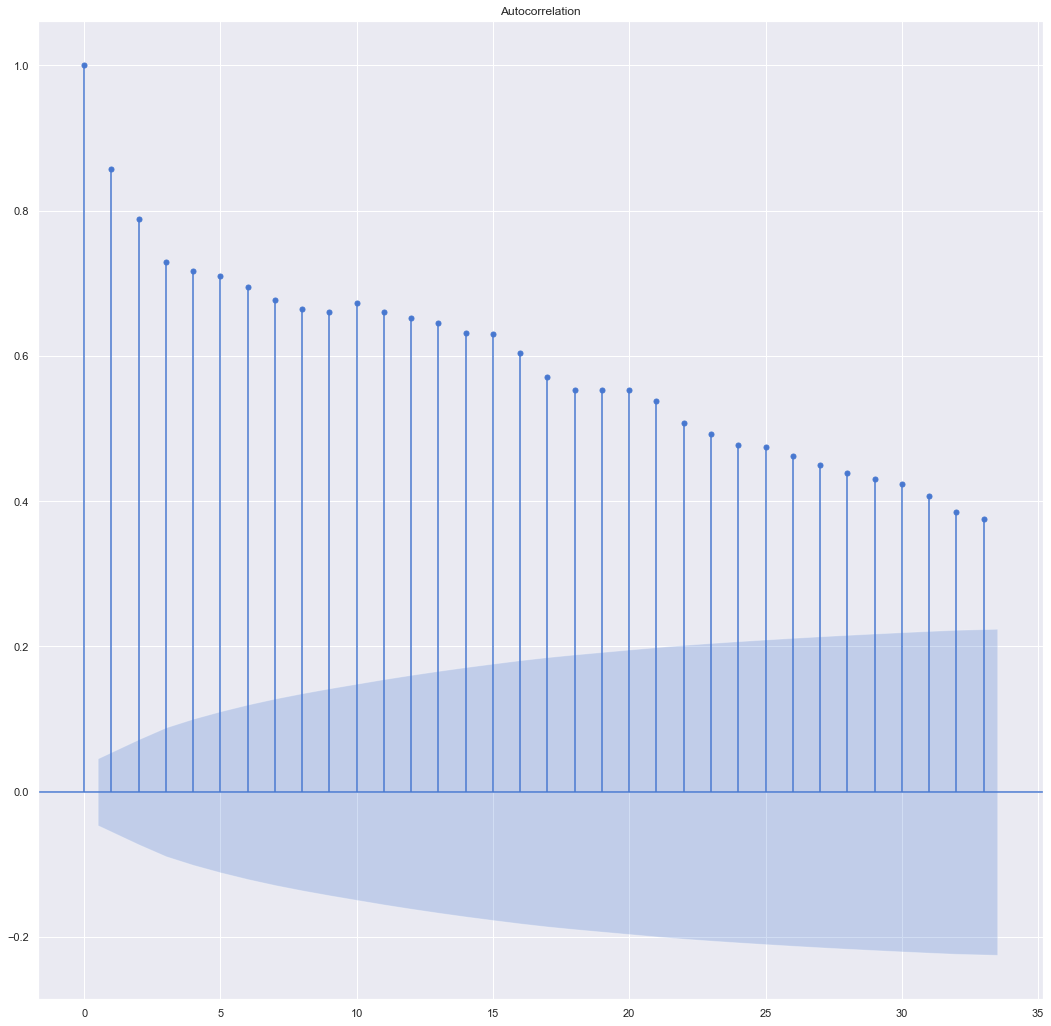

In [6]:
#Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data);

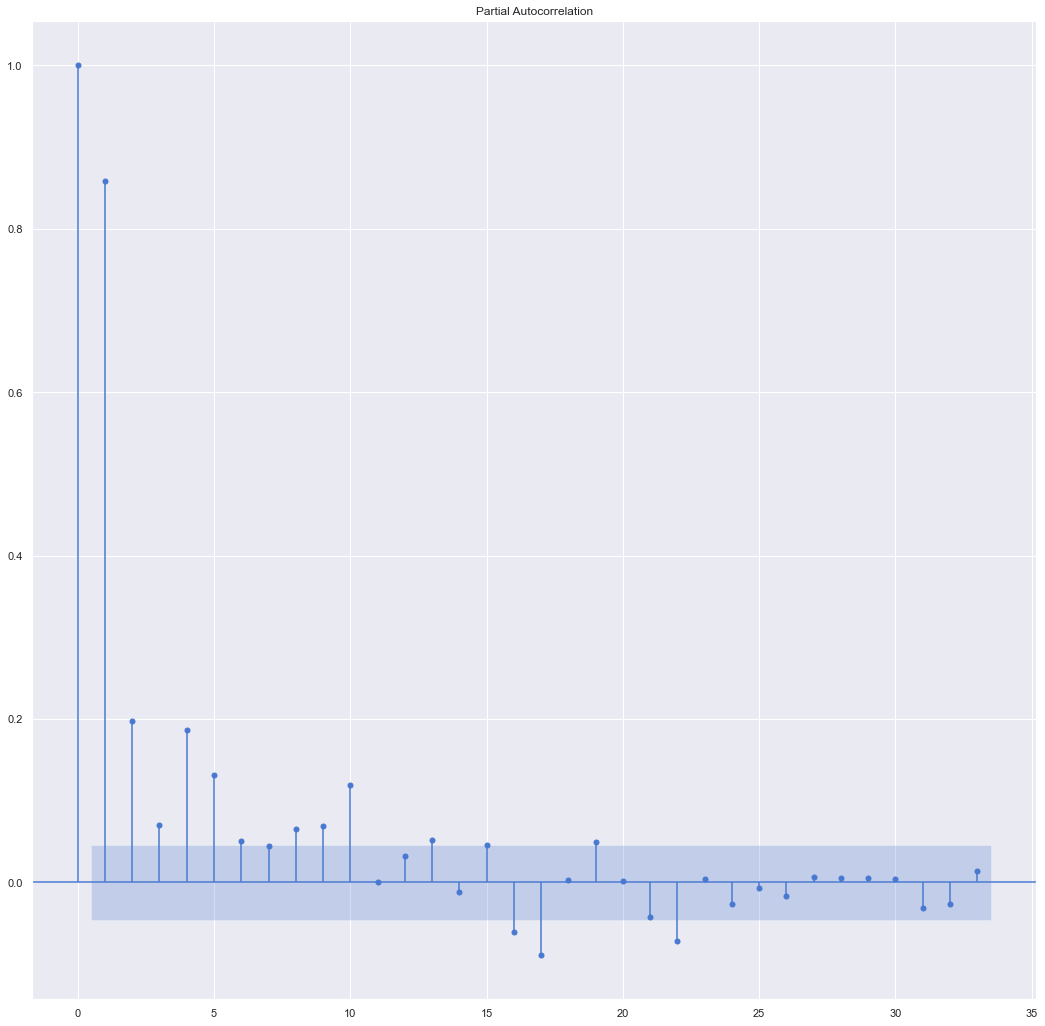

In [7]:
#partial autocorrelation
plot_pacf(data);

In [8]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
model = Sequential()
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

df= scaler.fit_transform(data)

In [12]:
#creating feature and label sets
features_set = []
labels = []
for i in range(60, 1814):
    features_set.append(df[i-60:i, 0])
    labels.append(df[i,0])

In [13]:
#converting both the feature_set and the labels list to the numpy array before we can use it for training
features_set, labels = np.array(features_set), np.array(labels)

In [14]:
#fitting it for the model dimension
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [15]:
#Training the LSTM 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [16]:
model = Sequential()

In [17]:
#adding LSTM layer to the model
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

In [18]:
#Adding dropout layer to avoid over-fitting (a situation where a machine learning model performs better on the training data compared to the test data.)
model.add(Dropout(0.2))

In [19]:
#adding 3 more LSTM and dropout models
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

In [20]:
#adding a dense layer at the end of the model to make it more robust(set to 1 since we want to predict a single value in the output)
model.add(Dense(units = 1))

In [21]:
#compiling our LSTM before we can train it on the training data
#the mean squared error is used as loss function and to reduce the loss or to optimize the algorithm,the adam optimizer is used.
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [22]:
#calling the fit method on the model and pass it our training features and labels
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
55/55 [==============================] - 16s 116ms/step - loss: 0.0106
Epoch 2/100
55/55 [==============================] - 6s 115ms/step - loss: 0.0068
Epoch 3/100
55/55 [==============================] - 6s 114ms/step - loss: 0.0066
Epoch 4/100
55/55 [==============================] - 6s 114ms/step - loss: 0.0062
Epoch 5/100
55/55 [==============================] - 6s 114ms/step - loss: 0.0063
Epoch 6/100
55/55 [==============================] - 6s 111ms/step - loss: 0.0065
Epoch 7/100
55/55 [==============================] - 6s 114ms/step - loss: 0.0061
Epoch 8/100
55/55 [==============================] - 6s 114ms/step - loss: 0.0064
Epoch 9/100
55/55 [==============================] - 6s 115ms/step - loss: 0.0060
Epoch 10/100
55/55 [==============================] - 6s 112ms/step - loss: 0.0058
Epoch 11/100
55/55 [==============================] - 6s 115ms/step - loss: 0.0057
Epoch 12/100
55/55 [==============================] - 6s 114ms/step - loss: 0.0058
Epoch 13/100

In [23]:
#importing test data
col_list = ["Date","SO2"]
data1 = pd.read_csv("O3Dt.csv", usecols=col_list,index_col ="Date")
data1.dropna(subset = ["SO2"], inplace=True)
data1.head()

,SO2
Date,
4/8/2020,12.85
4/9/2020,14.20
4/10/2020,16.32
4/11/2020,18.38
4/12/2020,15.70


In [24]:
#concatenating our training data and test data before preprocessing
datat = pd.concat((data['SO2'], data1['SO2']), axis=0)

In [25]:
#fetching 60 days values for test input
test_inputs = datat[len(datat) - len(data1) - 60:].values

In [26]:
#scaling our test data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [27]:
#preparing our final test input set containing pollutant level for 60 days
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])

In [28]:
#converting our data into 3-d format which can be used as input to the LSTM
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [29]:
#Making the prediction
predictions = model.predict(test_features)

In [30]:
#Using scaler inverse transform to reverse the scaled prediction back to their actual values
predictions = scaler.inverse_transform(predictions)

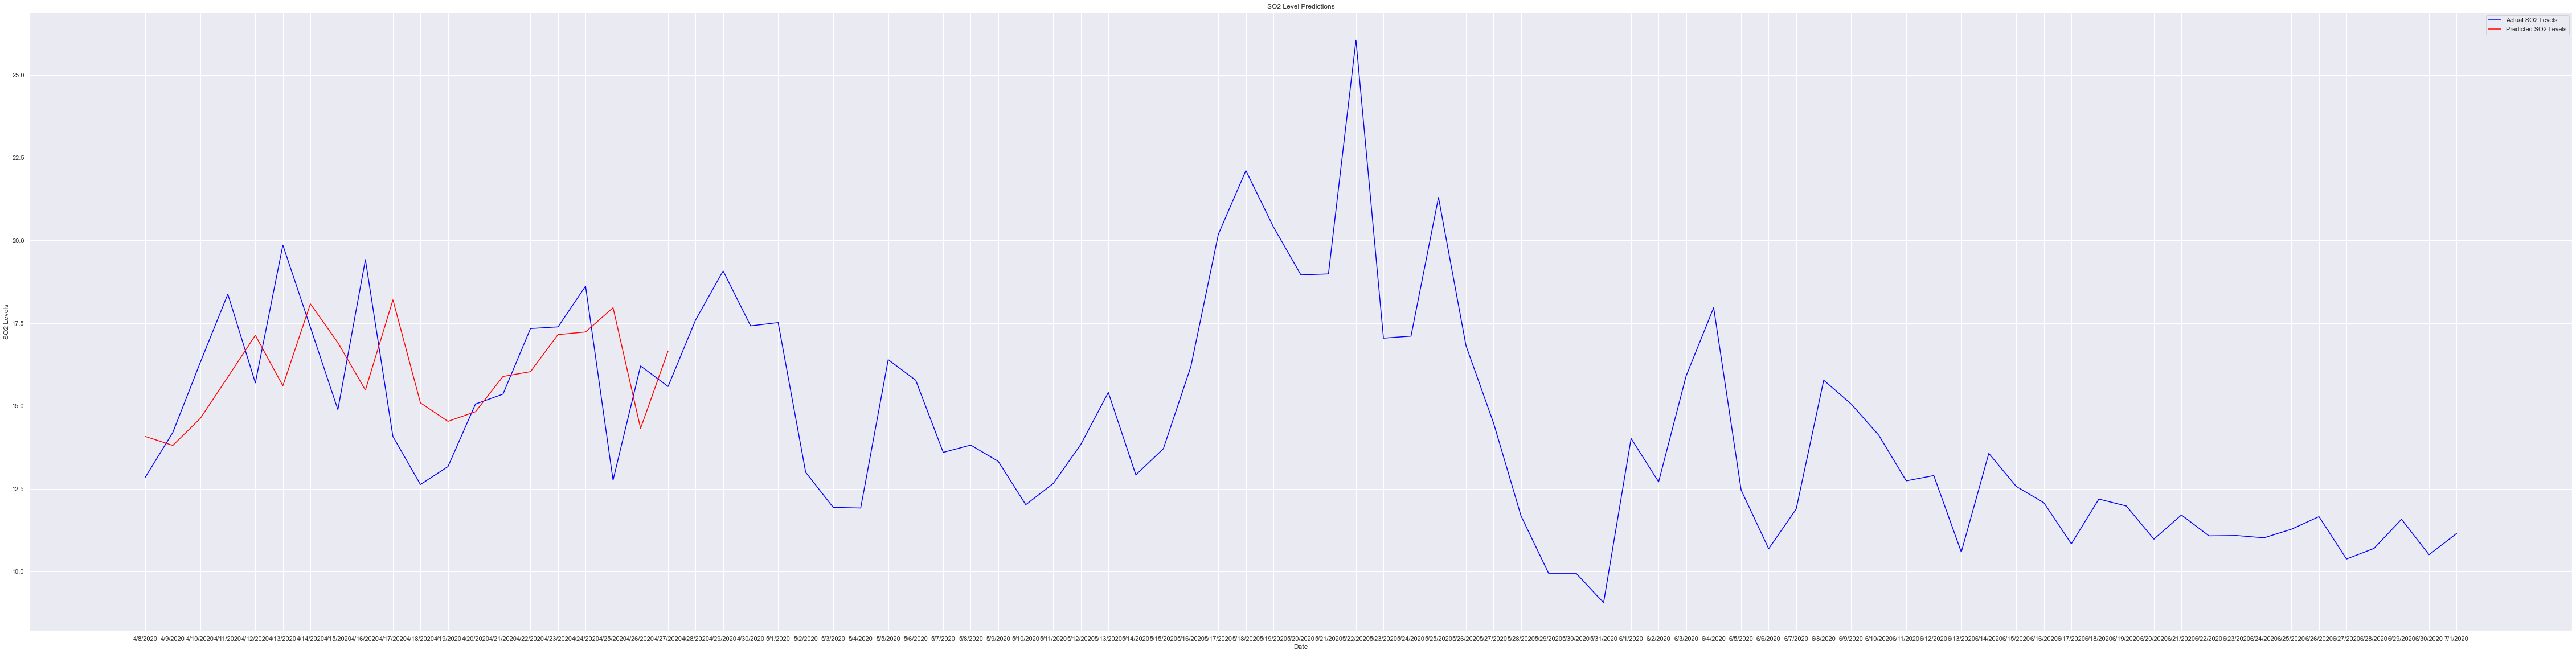

In [31]:
#Visualizing the prediction
plt.figure(figsize=(80,20))
plt.plot(data1, color='blue', label='Actual SO2 Levels')
plt.plot(predictions , color='red', label='Predicted SO2 Levels')
plt.title('SO2 Level Predictions')
plt.xlabel('Date')
plt.ylabel('SO2 Levels')
plt.legend()
plt.show()